In [1]:
"""
The double DQN based on this paper: https://arxiv.org/abs/1509.06461
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
Tensorflow: 1.0
gym: 0.8.0
"""

import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(1)


class DoubleDQN:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.005,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=200,
            memory_size=3000,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
            double_q=True,
            sess=None,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        self.double_q = double_q    # decide to use double q or not

        self.learn_step_counter = 0
        self.memory = np.zeros((self.memory_size, n_features*2+2))
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        if sess is None:
            self.sess = tf.Session()
            self.sess.run(tf.global_variables_initializer())
        else:
            self.sess = sess
        if output_graph:
            tf.summary.FileWriter("logs/", self.sess.graph)
        self.cost_his = []

    def _build_net(self):
        def build_layers(s, c_names, n_l1, w_initializer, b_initializer):
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(s, w1) + b1)

            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                out = tf.matmul(l1, w2) + b2
            return out
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss

        with tf.variable_scope('eval_net'):
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 20, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            self.q_eval = build_layers(self.s, c_names, n_l1, w_initializer, b_initializer)

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            self.q_next = build_layers(self.s_, c_names, n_l1, w_initializer, b_initializer)

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = np.hstack((s, [a, r], s_))
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition
        self.memory_counter += 1

    def choose_action(self, observation):
        observation = observation[np.newaxis, :]
        actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
        action = np.argmax(actions_value)

        if not hasattr(self, 'q'):  # record action value it gets
            self.q = []
            self.running_q = 0
        self.running_q = self.running_q*0.99 + 0.01 * np.max(actions_value)
        self.q.append(self.running_q)

        if np.random.uniform() > self.epsilon:  # choosing action
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            print('\ntarget_params_replaced\n')

        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval4next = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={self.s_: batch_memory[:, -self.n_features:],    # next observation
                       self.s: batch_memory[:, -self.n_features:]})    # next observation
        q_eval = self.sess.run(self.q_eval, {self.s: batch_memory[:, :self.n_features]})

        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        if self.double_q:
            max_act4next = np.argmax(q_eval4next, axis=1)        # the action that brings the highest value is evaluated by q_eval
            selected_q_next = q_next[batch_index, max_act4next]  # Double DQN, select q_next depending on above actions
        else:
            selected_q_next = np.max(q_next, axis=1)    # the natural DQN

        q_target[batch_index, eval_act_index] = reward + self.gamma * selected_q_next

        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1


In [ ]:
"""
Double DQN & Natural DQN comparison,
The Pendulum example.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
Tensorflow: 1.0
gym: 0.8.0
"""


import gym
#from RL_brain import DoubleDQN
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


env = gym.make('Pendulum-v0')
env = env.unwrapped
env.seed(1)
MEMORY_SIZE = 3000
ACTION_SPACE = 11

sess = tf.Session()
with tf.variable_scope('Natural_DQN'):
    natural_DQN = DoubleDQN(
        n_actions=ACTION_SPACE, n_features=3, memory_size=MEMORY_SIZE,
        e_greedy_increment=0.001, double_q=False, sess=sess
    )

with tf.variable_scope('Double_DQN'):
    double_DQN = DoubleDQN(
        n_actions=ACTION_SPACE, n_features=3, memory_size=MEMORY_SIZE,
        e_greedy_increment=0.001, double_q=True, sess=sess, output_graph=True)

sess.run(tf.global_variables_initializer())


def train(RL):
    total_steps = 0
    observation = env.reset()
    while True:
        # if total_steps - MEMORY_SIZE > 8000: env.render()

        action = RL.choose_action(observation)

        f_action = (action-(ACTION_SPACE-1)/2)/((ACTION_SPACE-1)/4)   # convert to [-2 ~ 2] float actions
        observation_, reward, done, info = env.step(np.array([f_action]))

        reward /= 10     # normalize to a range of (-1, 0). r = 0 when get upright
        # the Q target at upright state will be 0, because Q_target = r + gamma * Qmax(s', a') = 0 + gamma * 0
        # so when Q at this state is greater than 0, the agent overestimates the Q. Please refer to the final result.

        RL.store_transition(observation, action, reward, observation_)

        if total_steps > MEMORY_SIZE:   # learning
            RL.learn()

        if total_steps - MEMORY_SIZE > 3:   # stop game
            break

        observation = observation_
        total_steps += 1
    return RL.q

q_natural = train(natural_DQN)
q_double = train(double_DQN)

plt.plot(np.array(q_natural), c='r', label='natural')
plt.plot(np.array(q_double), c='b', label='double')
plt.legend(loc='best')
plt.ylabel('Q eval')
plt.xlabel('training steps')
plt.grid()
plt.show()

[2019-08-13 14:31:27,298] Making new env: Pendulum-v0


Instructions for updating:
Colocations handled automatically by placer.


/Users/valarian/python/miniconda3/lib/python3.7/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-08-13 14:31:27,316] From /Users/valarian/python/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.



target_params_replaced



In [1]:
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt
import seaborn as sb

In [4]:
a = [1,2,3]
b = a.pop()
a

[1, 2]

In [129]:
target = np.random.choice(np.arange(10), 1)
target[0]

6

In [28]:
np.random.randint(0, 9)

6

In [11]:
a = np.array([1.0*int(360/9)]*9)
b = np.array([2.0*int(360/9)]*9)
c = (b-a)[np.newaxis, :]
c

array([[40., 40., 40., 40., 40., 40., 40., 40., 40.]])

In [253]:
# 程序仿真部分

import numpy as np
import pandas as pd
from numba import jit

class Area():
    def __init__(self, n, a_id):
        self.a_id = a_id
        self.normal_bike = n
        self.broken_bike = 0

    def move(self):
        self.normal_bike -= 1
        self.broken_bike += 1


def binaryInsert(target, events):
    for event in events:
        if event >= target[-1]:
            target.append(event)
        else:
            l, mid, r = 0, int(len(target) / 2), len(target) - 1
            while 1:
                if r - l == 1:
                    target.insert(r, event)
                    break
                else:
                    if event > target[mid]:
                        l = mid
                        mid = int((r + l) / 2)
                    else:
                        r = mid
                        mid = int((r + l) / 2)


def simulate(N, R, A, Q, P, t_limit):
    '''
    N: initial number of bikes in the network
    R: rates of arriving and departing for each node
    A: number of Areas
    Q: matrix of tansitition probability
    P: policy of dealing with broken bikes

    T: system clock
    scheduler: stack of upcoming events,[t, event_type, area], 1 for customer arrival, 2 for bike arrival
    
    stat: record of system state parameters
    loss: record of customer loss
    '''

    # initiate
    T = 0
    #stat, S = pd.DataFrame(columns=['type', 'place', 't']), 0
    loss, L = pd.DataFrame(columns=['place', 't']), 0
    broken, B = pd.DataFrame(columns=['place', 'ng', 'nb', 't']), 0

    # initiation of instances of Area and scheduler
    scheduler = []
    a = []
    for i in range(A):
        a.append(Area(N / A, i))
        scheduler.append([np.random.exponential(1/R.loc[i].cus_arr), 1, a[i]])
    scheduler.sort()

    # system running
    while T < t_limit:
        
        T = scheduler[0][0]
        if scheduler[0][1] == 1:
            #stat.loc[S], S = [scheduler[0][1], scheduler[0][2].a_id, T], S+1
            if scheduler[0][2].normal_bike == 0:
                # this is a loss
                loss.loc[L], L = [scheduler[0][2].a_id, T], L+1
                event = [T + np.random.exponential(1/R.loc[scheduler[0][2].a_id].cus_arr), 1, scheduler[0][2]]
                binaryInsert(scheduler, [event])
            else:
                target = np.random.choice(np.arange(A+1), 1, p=Q[scheduler[0][2].a_id])
                if target == A:
                    broken.loc[B], B = [scheduler[0][2].a_id, scheduler[0][2].normal_bike, scheduler[0][2].broken_bike, T], B+1
                    scheduler[0][2].move()
                    continue
                else:
                    scheduler[0][2].normal_bike -= 1
                    event1 = [T + np.random.exponential(1/R.loc[scheduler[0][2].a_id].ride), 2, a[target[0]]]
                    event2 = [T + np.random.exponential(1/R.loc[scheduler[0][2].a_id].cus_arr), 1, scheduler[0][2]]
                    binaryInsert(scheduler, [event1, event2])
        else:
            #stat.loc[S], S = [scheduler[0][1], scheduler[0][2].a_id, T], S+1
            scheduler[0][2].normal_bike += 1
        scheduler.pop(0)
        
    #return stat
    return loss, broken

if __name__ == '__main__':
    np.random.seed(1)
    N = 360
    A = 9
    R = pd.DataFrame({'cus_arr': [5] * A, 'ride': [10] * A}, index=range(A))
    Q = [np.random.rand(A+1) for i in range(A)]
    Q = [q / sum(q) for q in Q]
    #Q = [[0,0.9,0.1], [0.9,0,0.1]]
    P = 0
    time_limit = 6000

    result = simulate(N, R, A, Q, P, time_limit)


In [254]:
result[1]

,place,ng,nb,t
0,0.0,6.0,0.0,2.593297
1,0.0,4.0,1.0,2.617673
2,1.0,5.0,0.0,2.857976
3,1.0,6.0,1.0,3.388227
4,1.0,1.0,2.0,3.981953
5,0.0,1.0,2.0,4.711564
6,0.0,1.0,3.0,5.525344
7,1.0,2.0,3.0,5.848935
8,0.0,2.0,4.0,6.063252
9,1.0,1.0,4.0,7.968719


In [233]:
r1 = result[result.place==0.0]
r2 = result[result.place==1.0]

In [244]:
np.average(r2[r2.type == 1.0].t.diff()[1:])

0.20150611825636044

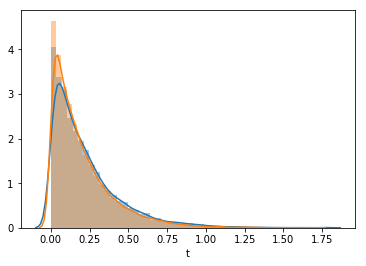

In [245]:
sb.distplot(r2[r2.type == 2.0].t.diff()[1:])
sb.distplot(np.random.exponential(1/5, 20000))

In [225]:
temp.s = temp.t.diff()
temp

,n,place,t,s
3,6.0,1.0,0.160275,NaN
5,7.0,1.0,0.254825,0.094551
10,7.0,1.0,0.444134,0.189309
11,8.0,1.0,0.456272,0.012137
13,9.0,1.0,0.675765,0.219493
18,8.0,1.0,0.850911,0.175147
20,9.0,1.0,1.114521,0.263610
33,5.0,1.0,1.535464,0.420943
37,5.0,1.0,1.690776,0.155311
39,6.0,1.0,1.745220,0.054444


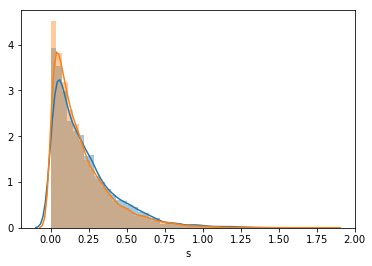

In [227]:

sb.distplot(temp[1:].s)
sb.distplot(np.random.exponential(0.2, 20000))

In [217]:
np.average(rl0[1:].s)

0.11186950161247063

In [206]:
rl1 = result[result.place == 0.0]

In [209]:
rl1['s'] = rl1.t.diff()

/Users/valarian/python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [210]:
np.average(rl1[1:].s)

0.11183645412846409

In [175]:
np.random.choice(np.arange(3), 1, p=[1,0,0])

array([0])

In [29]:
a[8].normal_bike

10.0